In [ ]:
%pip install tensorflow
%pip install keras-tuner --upgrade
%pip install opencv-python
%pip install optuna

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import optuna
import pickle

# We'll build the CNN as a sequence of layers.
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, LeakyReLU, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras import layers, Model
# Libraries to handle the data
import json
import os
from tqdm import tqdm
from PIL import Image
import cv2
from keras.applications import MobileNetV2

from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras import backend as K
import keras_tuner as kt
import cv2
import seaborn as sns



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 12.7 MB/s eta 0:00:00


In [ ]:
!unzip "/content/archive (8).zip"

Streaming output truncated to the last 5000 lines.
  inflating: planesnet/planesnet/1__20170222_231256_0c27__-122.38315357_37.6157415688.png  
  inflating: planesnet/planesnet/1__20170222_231256_0c27__-122.383170478_37.6145066674.png  
  inflating: planesnet/planesnet/1__20170222_231256_0c27__-122.383729791_37.6187867125.png  
  inflating: planesnet/planesnet/1__20170222_231256_0c27__-122.384510263_37.6198917809.png  
  inflating: planesnet/planesnet/1__20170222_231256_0c27__-122.385179849_37.6188192613.png  
  inflating: planesnet/planesnet/1__20170222_231256_0c27__-122.3876445_37.6207868997.png  
  inflating: planesnet/planesnet/1__20170222_231256_0c27__-122.388117_37.6182480314.png  
  inflating: planesnet/planesnet/1__20170222_231256_0c27__-122.389382406_37.6201492015.png  
  inflating: planesnet/planesnet/1__20170222_231256_0c27__-122.389931176_37.6215474909.png  
  inflating: planesnet/planesnet/1__20170222_231256_0c27__-122.390283641_37.6180147081.png  
  inflating: planesnet/pl

In [ ]:
%lsn

UsageError: Line magic function `%lsn` not found.


In [ ]:
with open('planesnet.json', 'r') as file:
    planesnet = json.load(file)

data = np.array(planesnet['data'])
labels = np.array(planesnet['labels'])

In [ ]:
labels.shape

(32000,)

In [ ]:
def create_data(path_name):
    images = []
    labels = []
    for img in tqdm(os.listdir(path_name)):
        if(img[0]=='1'):
            labels.append(1)
        else:
            labels.append(0)
        image = Image.open(os.path.join(path_name,img))
        image = np.array(image)
        images.append(image)

    return np.array(images),np.array(labels)

images, labels = create_data("planesnet/planesnet")

100%|██████████| 32000/32000 [00:03<00:00, 8066.47it/s]


In [ ]:
###Check the Array of Data

images.shape




(32000, 20, 20, 3)

In [ ]:
### Check the Labels and Shape

print(images[0].shape)
print(labels[31999])

(20, 20, 3)
1


In [ ]:
### Print the IMGs from Directory
for img in tqdm(os.listdir('planesnet/planesnet')[31000:31020]):
    print(img)

100%|██████████| 20/20 [00:00<00:00, 52200.42it/s]

0__20161110_180707_0e1f__-122.101400644_37.649002529.png
0__20170511_180559_1031__-122.10210131082306_37.77703836995198.png
0__20170524_174812_102d__-118.429722682_33.9430763398.png
0__20160814_203136_0c13__-117.06700951306563_32.65497969994593.png
0__20170722_175150_1033__-118.56327835831715_34.0077596863232.png
0__20160222_170515_0b0a__-117.204909283_32.7340960604.png
1__20170416_174735_0e0e__-117.203460255_32.7329188996.png
0__20161118_174611_0e30__-117.88460645576146_33.65450348300919.png
0__20150318_183154_0905__-121.853137916_37.341437668.png
1__20170101_201603_0c22__-118.404737794_33.9326810922.png
1__20170513_174817_0f10__-118.406287309_33.9418445272.png
1__20170101_180919_0e30__-122.390646809_37.621070634.png
0__20170727_174407_1033__-117.0664873158322_32.68420754024547.png
0__20170419_175114_0e19__-117.84401507445247_33.68233139354718.png
0__20151112_182751_0c47__-117.91639339854424_33.61625682276027.png
1__20170619_174325_1004__-117.20332809835271_32.73415092927228.png
0__20

In [ ]:
### Normalize the Images -> Helps standardize coefficients/ gets rid of vanishing gradient
images = images / 255

In [ ]:
images.shape

(32000, 20, 20, 3)

In [ ]:
from sklearn.model_selection import train_test_split

### Set the Training and Testing Split to 30% Test, 70% Train
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=42, stratify=labels)

In [ ]:
### Check the Split
np.unique(y_train, return_counts=True)

(array([0, 1]), array([16800,  5600]))

In [ ]:
# Reshape the input data to flatten the images
X_train_sub_flattened = X_train.reshape(X_train.shape[0], -1)
Y_train_sub_flattened = y_train.reshape(y_train.shape[0], -1)


x_test_flattened = X_test.reshape(X_test.shape[0], -1)
y_test_flattened = y_test.reshape(y_test.shape[0], -1)

In [ ]:
X_train_sub_flattened.shape

(22400, 1200)

In [ ]:
print(images[0].shape)

(20, 20, 3)


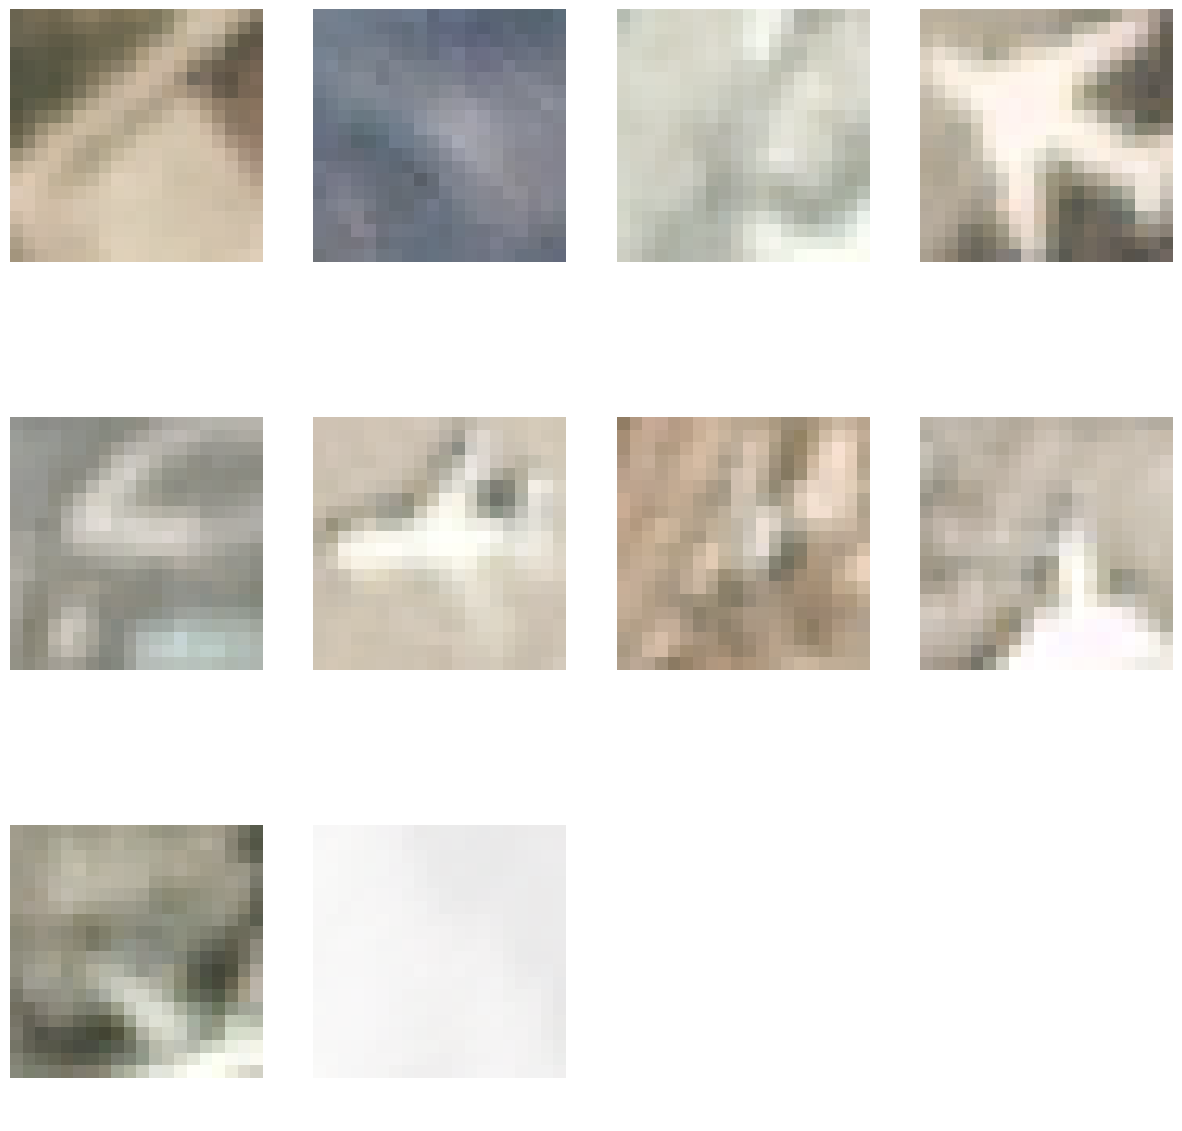

In [ ]:
### View some of the images
import matplotlib.pyplot as plt

# Function to display a subset of original images
def display_original_images(images, titles=None, cols=4, start=0, end=None):
    if end is None:
        end = len(images)
    rows = (end - start + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
    for i, ax in enumerate(axes.flat):
        idx = start + i
        if idx < end:
            ax.imshow(images[idx])
            ax.axis('off')
            if titles:
                ax.set_title(titles[idx])
        else:
            ax.axis('off')
    plt.show()

# Example usage: Display original images from index 0 to 9
display_original_images(images, start=0, end=10)


In [ ]:
### Now I am working on Image Data Augmentation
%pip install opencv-python
import random
import cv2

def batch_random_rotation(images, labels, angle_range=(-10, 10)):
    rotated_images = []
    rotated_labels = []
    for image, label in zip(images, labels):
        angle = random.randint(angle_range[0], angle_range[1])
        rows, cols, _ = image.shape
        M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
        rotated_image = cv2.warpAffine(image, M, (cols, rows))
        rotated_images.append(rotated_image)
        rotated_labels.append(label)

    # Concatenate original and augmented data
    return np.concatenate((images, np.array(rotated_images))), np.concatenate((labels, np.array(rotated_labels)))


def batch_random_shift(images, labels, shift_range=(-0.1, 0.1)):
    shifted_images = []
    shifted_labels = []
    for image, label in zip(images, labels):
        h, w, _ = image.shape
        tx = random.uniform(shift_range[0] * w, shift_range[1] * w)
        ty = random.uniform(shift_range[0] * h, shift_range[1] * h)
        M = np.float32([[1, 0, tx], [0, 1, ty]])
        shifted_image = cv2.warpAffine(image, M, (w, h))
        shifted_images.append(shifted_image)
        shifted_labels.append(label)

    # Concatenate original and augmented data
    return np.concatenate((images, np.array(shifted_images))), np.concatenate((labels, np.array(shifted_labels)))

def batch_random_flip(images, labels, p=0.5):
    flipped_images = []
    flipped_labels = []
    for image, label in zip(images, labels):
        flipped_images.append(image)  # Add original first
        flipped_labels.append(label)
        if random.random() < p:
            flipped_image = cv2.flip(image, 1)  # Horizontal flip
            flipped_images.append(flipped_image)
            flipped_labels.append(label)

    # Concatenate original and augmented data
    return np.array(flipped_images), np.array(flipped_labels)



# Example usage:
# Assuming img is your original image

X_train, y_train = batch_random_rotation(X_train, y_train)

# Apply shift augmentation
X_train, y_train = batch_random_shift(X_train, y_train)

# Apply flip augmentation
X_train, y_train = batch_random_flip(X_train, y_train)

In [ ]:
image_array = np.array(X_train)

In [ ]:
image_array.shape

(134441, 20, 20, 3)

In [ ]:
np.unique(y_train, return_counts=True)

(array([0, 1]), array([100883,  33558]))

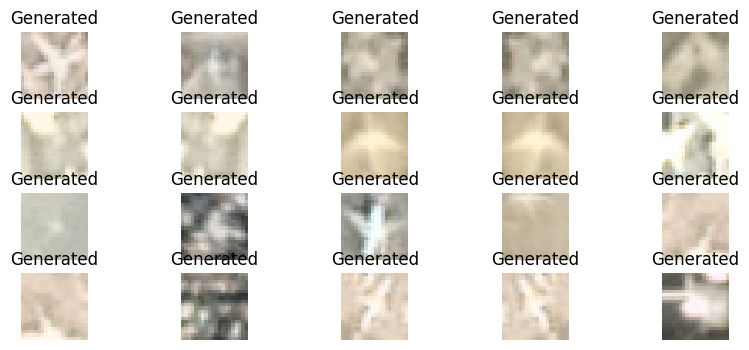

In [ ]:

import matplotlib.pyplot as plt
num_samples = 20
# Set up the figure
plt.figure(figsize=(10, 4))
for i in range(num_samples):
    # Display each image in a subplot
    ax = plt.subplot(4, 5, i + 1)
    plt.imshow(image_array[i])
    plt.title("Generated")
    plt.axis('off')
plt.show()

In [ ]:
def build_generator(latent_dim, num_classes):
    noise = layers.Input(shape=(latent_dim,))
    label = layers.Input(shape=(1,))
    label_embedding = layers.Embedding(num_classes, latent_dim)(label)
    label_embedding = layers.Flatten()(label_embedding)

    merged = layers.Concatenate()([noise, label_embedding])

    # Reduced the size of the Dense layer since the output image is much smaller
    x = layers.Dense(128 * 5 * 5, activation=tf.keras.layers.LeakyReLU(alpha=0.2))(merged)
    x = layers.Reshape((5, 5, 128))(x)
    x = layers.BatchNormalization()(x)

    # Adjust the Conv2DTranspose layers to achieve the final image size of 20x20
    x = layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding="same", activation=tf.keras.layers.LeakyReLU(alpha=0.2))(x)  # 10x10
    x = layers.BatchNormalization()(x)
    x = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding="same", activation=tf.keras.layers.LeakyReLU(alpha=0.2))(x)  # 20x20
    x = layers.BatchNormalization()(x)
    x = layers.Conv2DTranspose(3, (3, 3), strides=(1, 1), padding="same", activation="tanh")(x)  # 20x20

    return Model([noise, label], x)

def build_discriminator(image_shape, num_classes):
    image = layers.Input(shape=image_shape)
    label = layers.Input(shape=(1,))
    label_embedding = layers.Embedding(num_classes, np.prod(image_shape))(label)
    label_embedding = layers.Reshape(image_shape)(label_embedding)

    merged = layers.Concatenate()([image, label_embedding])

    # Adjust the Conv2D layers for smaller input
    x = layers.Conv2D(64, (3, 3), strides=(1, 1), padding="same", activation=tf.keras.layers.LeakyReLU(alpha=0.2))(merged)  # 20x20
    x = layers.Conv2D(32, (3, 3), strides=(1, 1), padding="same", activation=tf.keras.layers.LeakyReLU(alpha=0.2))(x)  # 20x20
    x = layers.Flatten()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(1, activation="sigmoid")(x)

    return Model([image, label], x)


def discriminator_loss(real_output, fake_output):
    real_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output)
    fake_loss = tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
    total_loss = (real_loss + fake_loss) * 0.5
    return total_loss

def generator_loss(true_labels, fake_output):
    return tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)

# Set model parameters
latent_dim = 100
num_classes = 2  # You have two classes, 0 and 1
generator = build_generator(latent_dim, num_classes)
discriminator = build_discriminator((20, 20, 3), num_classes)

# Compiling the discriminator
discriminator.compile(optimizer=Adam(1e-4), loss=discriminator_loss)

discriminator.trainable = False
gan_input = [generator.input[0], generator.input[1]]  # noise and label input
gan_output = discriminator([generator.output, generator.input[1]])  # output of generator and input label
gan = tf.keras.models.Model(gan_input, gan_output)

gan.compile(optimizer=Adam(1e-2), loss=generator_loss)

batch_size = 256

def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch, label_batch in dataset:
            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            generated_images = generator.predict([noise, label_batch])

            # Train the discriminator (real classified as 1 and fakes as 0)
            discriminator.trainable = True  # Ensure discriminator is trainable for this phase
            d_loss_real = discriminator.train_on_batch([image_batch, label_batch], tf.ones((batch_size, 1)))
            d_loss_fake = discriminator.train_on_batch([generated_images, label_batch], tf.zeros((batch_size,1)))
            d_loss = 0.5 *  np.add(d_loss_real, d_loss_fake)

            # Train the generator (trick discriminator to classify fakes as real)
            discriminator.trainable = False  # This line is redundant after the first iteration unless you recompile the GAN model
            g_loss = gan.train_on_batch([noise, label_batch], tf.ones((batch_size, 1)))

            print(f"Epoch: {epoch} [D loss: {d_loss}] [G loss: {g_loss}]")

# Call the train function
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size, drop_remainder=True)
train(dataset, epochs=8)

Streaming output truncated to the last 5000 lines.
8/8 [==============================] - 0s 2ms/step
Epoch: 3 [D loss: 3.8562417094375685] [G loss: 10.905351638793945]
8/8 [==============================] - 0s 2ms/step
Epoch: 3 [D loss: 3.85624219870296] [G loss: 10.88779067993164]
8/8 [==============================] - 0s 2ms/step
Epoch: 3 [D loss: 3.8562417149857176] [G loss: 10.878681182861328]
8/8 [==============================] - 0s 2ms/step
Epoch: 3 [D loss: 3.8562417081893186] [G loss: 10.892692565917969]
8/8 [==============================] - 0s 2ms/step
Epoch: 3 [D loss: 3.8562421830545057] [G loss: 10.86716079711914]
8/8 [==============================] - 0s 2ms/step
Epoch: 3 [D loss: 3.856242189543133] [G loss: 10.901875495910645]
8/8 [==============================] - 0s 2ms/step
Epoch: 3 [D loss: 3.8562417066152035] [G loss: 10.903216361999512]
8/8 [==============================] - 0s 2ms/step
Epoch: 3 [D loss: 3.8562421842755845] [G loss: 10.904982566833496]
8/8 [=====

In [ ]:
classes, counts = np.unique(y_train, return_counts=True)

minority_class = 1
majority_class = 0

# Identifying counts
minority_count = counts[np.where(classes == minority_class)[0][0]]
majority_count = counts[np.where(classes == majority_class)[0][0]]

In [ ]:
num_samples = majority_count - minority_count  # Adjust this to the number of additional samples you need

# Generate random noise vectors
noise = np.random.normal(0, 1, (num_samples, latent_dim))

new_labels = np.ones((num_samples, 1))

new_labels  = new_labels.flatten()

In [ ]:
generated_images = generator.predict([noise, new_labels])

2104/2104 [==============================] - 4s 2ms/step


In [ ]:
generated_images.max()


0.4454588

In [ ]:
X_train = np.concatenate((X_train, generated_images), axis=0)

# Concatenate the original labels with the new labels
y_train = np.concatenate((y_train, new_labels), axis=0)

In [ ]:
y_train.shape

(201766,)

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV
import numpy as np
import pickle
import pandas as pd

In [ ]:
X_train_sub_flattened = X_train.reshape(X_train.shape[0], -1)
Y_train_sub_flattened = y_train.reshape(y_train.shape[0], -1)
Y_train_sub_flattened = Y_train_sub_flattened.ravel()

x_test_flattened = X_test.reshape(X_test.shape[0], -1)
y_test_flattened = y_test.reshape(y_test.shape[0], -1)
y_test_flattened = y_test_flattened.ravel()

In [ ]:
n_samples = 10000
indices = np.random.choice(X_train_sub_flattened.shape[0], n_samples, replace=False)

X_train_subset = X_train_sub_flattened[indices]
y_train_subset = Y_train_sub_flattened[indices]

In [ ]:
import optuna
from sklearn.svm import SVC
from sklearn.metrics import f1_score

def objective(trial):
    # Adjusted the ranges for C and gamma
    C = trial.suggest_loguniform('C', 1e-2, 1e2)
    gamma = trial.suggest_loguniform('gamma', 1e-5, 1e-1)

    # Assuming you want to use the RBF kernel, which uses both C and gamma
    svm_model = SVC(kernel='rbf', C=C, gamma=gamma, random_state=42)
    svm_model.fit(X_train_subset, y_train_subset)
    y_pred = svm_model.predict(x_test_flattened)
    return f1_score(y_test_flattened, y_pred)

study = optuna.create_study(direction='maximize')
# Reduced the number of trials
study.optimize(objective, n_trials=15)

[I 2024-04-23 19:06:45,537] A new study created in memory with name: no-name-3964c20b-14db-4bc1-8a06-76a40a2286e9
<ipython-input-34-1b0a3e268623>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)
<ipython-input-34-1b0a3e268623>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-5, 1e-1)
[I 2024-04-23 19:07:43,204] Trial 0 finished with value: 0.720814479638009 and parameters: {'C': 2.2825262169598677, 'gamma': 0.0007100564583205496}. Best is trial 0 with value: 0.720814479638009.
<ipython-input-34-1b0a3e268623>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This f

In [ ]:
best_params = study.best_params
best_score = study.best_value
best_trial = study.best_trial

In [ ]:
best_params

{'C': 15.18673537339232, 'gamma': 0.029162091678620584}

In [ ]:
svm_model = SVC(kernel='rbf', C=15.18673537339232, gamma=0.029162091678620584, random_state=42)

# Train the model on the training subset
svm_model.fit(X_train_subset, y_train_subset)

# Predict on the test set
y_pred = svm_model.predict(x_test_flattened)

In [ ]:
svm_model.evaluate(x_test_flattened, y_test_flattened)

AttributeError: 'SVC' object has no attribute 'evaluate'

In [ ]:
f1 = f1_score(y_test_flattened, y_pred)

print("F1 Score on Test Set:", f1)

conf_matrix_svc = confusion_matrix(y_test_flattened, y_pred)


F1 Score on Test Set: 0.8841183826594415


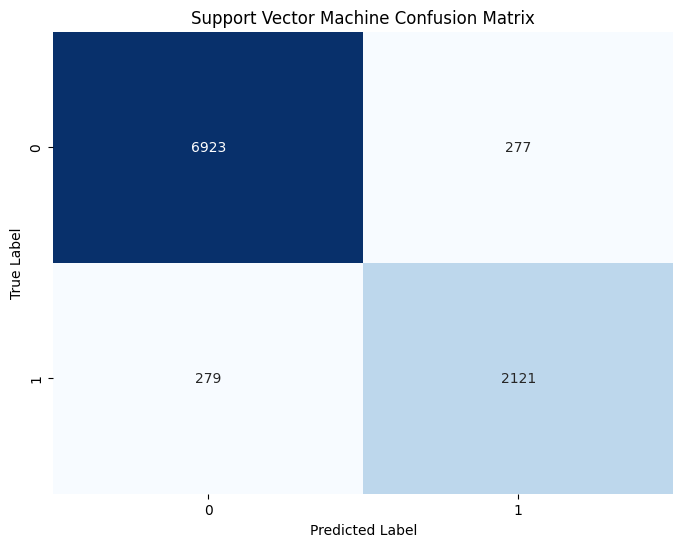

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_svc, annot=True, fmt="d", cmap='Blues', cbar=False)
plt.title('Support Vector Machine Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()